### Visualisation and analysis of `classify-classifications.csv`.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
from dateutil.parser import parse
from datetime import date

import sys
sys.path.append('..')
from sf import getFilename, parseTime, extract_task_value, percentageVotesForAnswer, make_df_tasks_with_props, make_df_vote_threshold

%matplotlib inline

In [2]:
# reload sf import while I'm working on extracting functionality to it from notebooks
from importlib import reload
import sf
reload(sf)

<module 'sf' from '..\\sf.py'>

In [3]:
# set matplotlib plotting params:
font = {
    'family': 'Verdana',
    'weight': '300',
    'size': 12
}

rc('font', **font)

- Load and inspect the dataframe.
- Parse stringified columns.
- Remove rows where the user didn't make a classification.

## Load parsed dataframes

In [4]:
object_info = pd.read_csv('../../catalogue/sf_spacefluff_object_data.csv', comment="#")

candidate_names_classify = np.loadtxt('../sf_candidate_names__classification-classify.txt', dtype='str')

catalogue_targets = np.loadtxt('../../catalogue/sf_catalogue_targets.txt', dtype='str')

answer_types = ['Galaxy', 'Group of objects (Cluster)', 'Something else/empty center']

In [5]:
df = pd.read_csv('./df.csv', delimiter=',')
df_tasks_with_props = make_df_tasks_with_props(df, candidate_names_classify, object_info)

---

In [6]:
# question: are all votes counted properly now?
print('Total votes:', df_tasks_with_props['# votes'].agg(['sum']), '\n')
print('Number of rows remaining in dataframe: ', df.shape[0])
# answer: yes, every row in the dataframe now contains a valid vote

Total votes: sum    92893.0
Name: # votes, dtype: float64 

Number of rows remaining in dataframe:  92893


---

### Group by filename for inspection:

In [7]:
gr_by_name = df.groupby(['Filename'])
groups = list(gr_by_name.groups)

# gr_name.get_group(groups[1])

# Inspect vote count per object

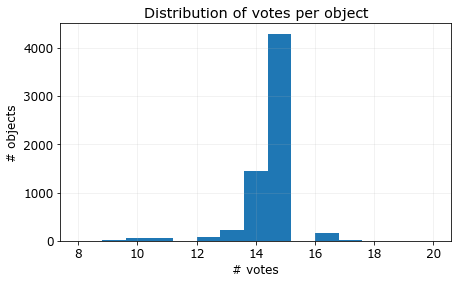

In [8]:
vote_counts = list(df_tasks_with_props['# votes'])  # Extract vote count:


# Plot histogram of votes per object:
fig, fr = plt.subplots(figsize=(7,4))

fr.hist(vote_counts, bins=15)
fr.grid(alpha=0.2, which='both')
fr.update({
    'xlabel': '# votes',
    'ylabel': '# objects',
    'title': 'Distribution of votes per object',
})

plt.show()

- Extract the occurrence rate of every `# votes` value:

In [9]:
def count_dict(entries):
    '''
    @params: entries: list of vals
    @returns: dictionary where the keys are the vals, and the values are the number of times each val occurs in entries
    '''
    count_dict = {}
    
    for key in set(entries):
        count_dict[key] = entries.count(key)
        
    return count_dict

In [10]:
count_dict(vote_counts)  # uncomment to inspect vote count occurrence rate

{8.0: 2,
 9.0: 13,
 10.0: 64,
 11.0: 63,
 12.0: 72,
 13.0: 217,
 14.0: 1454,
 15.0: 4289,
 16.0: 165,
 17.0: 12,
 18.0: 5,
 19.0: 3,
 20.0: 3}

---

## Back to inspecting vote distributions.

## Plot vote distributions

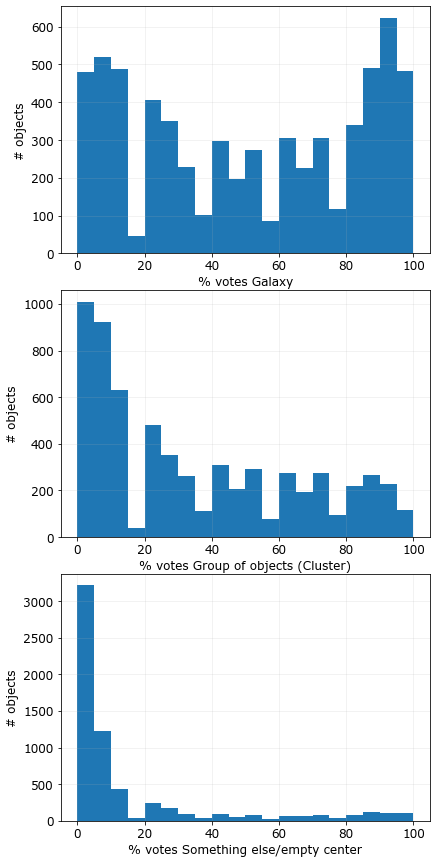

In [11]:
fields = ['% votes {}'.format(ans) for ans in answer_types]

fig, fr = plt.subplots(len(fields), figsize=(6, 12))
fig.tight_layout()

for idx, field in enumerate(fields):
    fr[idx].hist(df_tasks_with_props[field], bins=20)

    fr[idx].grid(alpha=0.2, which='both')
    fr[idx].update({
        'xlabel': field,
        'ylabel': '# objects'
    })

Of note: 
- votes for `galaxy` is a relatively two-sided distribution. Most likely are basically either 'definitely not a galaxy' and 'definitely a galaxy'.
    Looking at this distribution, a naive first approximation for 'certainty' in the people's vote might be, say, 75% votes for `galaxy`.
- votes for `cluster` is mostly 'no', but there are still plenty of objects where people do vote for `cluster`
- relatively few objects are supposedly `empty` or `something else`

Examine 'Task 1' results. 
- If task 0 answer is `galaxy`, task 1 asks "Is the galaxy fluffy or is it bright?"

In [12]:
# find classifications where people voted 'galaxy'
df_galaxy = df[(df['Task0'] == 'Galaxy') & (df['annotations'].map(len) > 1)]

---

In [13]:
# # sanity check: check if 'is the galaxy fluffy or is it bright?' is the only question asked 
# #    when people answer 'galaxy' in task 0
# # also check which answers are possible
# task1_questions = []
# task1_values = []

# for answer in answer_types[:1]:
#     df_filtered = df[(df['Task0'] == answer) & (df['annotations'].map(len) > 1)]
#     df_filtered['annotations'].apply(lambda x: task1_questions.append(x[1]['task_label']))
#     df_filtered['annotations'].apply(lambda x: task1_values.append(x[1]['value']))
    

# set(task1_questions)  # set of all questions asked (turns out, it's only the one above)
# set(task1_values)     # set of all answers. 
#                       # note this could also be found simply using df_galaxy.groupby(['Task1']).groups.keys()

---

In [14]:
gr_galaxy_task1 = df_galaxy.groupby(['Task1'])

print(df_galaxy.Task1.value_counts())  # count of 'Fluffy' and 'Bright'
print('None:', df_galaxy[df_galaxy['Task1'].isnull()].shape[0])  # count of None, presumably people didn't give an answer in this case

Fluffy    29792
Bright    16554
Name: Task1, dtype: int64
None: 639


---

## Plot % votes galaxy vs. % fluffy/bright

In [15]:
has_galaxy_votes = df_tasks_with_props[df_tasks_with_props['% votes Galaxy'] > 0]
has_galaxy_votes.head()

,name,% Fluffy,% Bright,% None,counts,# votes,% votes Galaxy,% votes Group of objects (Cluster),% votes Something else/empty center,RA,...,ge,re,ie,Reffe,r_mage,ne,C,mue_r,bae,RFF
0,UDGcand_3284,25.0,75.0,0.0,"{'Galaxy': 8, 'Group of objects (Cluster)': 7}",15.0,53.3,46.7,0.0,55.338791,...,0.127661,0.043053,0.041242,0.490387,0.144141,0.125983,4.040572,23.759357,0.029333,-99.0
1,UDGcand_781,83.3,16.7,0.0,"{'Galaxy': 12, 'Group of objects (Cluster)': 3}",15.0,80.0,20.0,0.0,52.873089,...,0.050087,0.041672,0.041842,0.153971,0.096408,0.092008,2.385606,23.007746,0.021571,-99.0
2,UDGcand_5340,0.0,100.0,0.0,"{'Something else/empty center': 11, 'Galaxy': 4}",15.0,26.7,0.0,73.3,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UDGcand_4322,50.0,50.0,0.0,"{'Something else/empty center': 9, 'Group of o...",15.0,13.3,26.7,60.0,54.964005,...,0.268916,0.202541,0.082005,0.629037,0.402274,0.280936,2.657395,25.677322,0.064266,-99.0
4,UDGcand_4731,91.7,8.3,0.0,"{'Galaxy': 12, 'Group of objects (Cluster)': 3}",15.0,80.0,20.0,0.0,54.233459,...,0.056441,0.046887,0.042970,0.259938,0.127845,0.114710,2.385606,23.535160,0.026763,-99.0


## Inspect the votes for objects that are in the post-selection catalogue:

In [16]:
def filterby_in_catalogue(df, catalogue, in_catalogue_bool):
    '''
    @param df: should be a version of df_tasks_with_props
    @param catalogue: list of objects in catalogue, from sf_catalogue_targets.txt
    @param {boolean} in_catalogue_bool: specify whether we want objects in or not in catalogue
    '''

    if in_catalogue_bool:
        return df[df['name'].isin(catalogue)]
    else:
        return df[~df['name'].isin(catalogue)]

In [17]:
def plot_galaxy_and_cluster_votes(fr, idx, filtered_df, title):
    '''
    @param filtered_df: response from filterby_in_catalogue
    @param fr: matplotlib plot
    @param {int} idx: fr index
    @param {string} title: plot title
    '''
    # plot histograms of vote distribution for the objects in the catalogue
    fr[idx].hist(filtered_df['% votes Group of objects (Cluster)'], alpha=0.6, label='Cluster', density=True)
    fr[idx].hist(filtered_df['% votes Galaxy'], alpha=0.75, label='Galaxy', density=True)

    fr[idx].update({
        'xlabel': '% votes Galaxy',
        'ylabel': 'normed # objects',
        'xlim': [0,100],
        'title': title
    })
    fr[idx].grid(alpha=0.2, which='both')
    fr[idx].legend()
    
def make_single_plot_galaxy_cluster(dfs, titles):
    fig, fr = plt.subplots(1,2, figsize=(12,4))
    
    for idx, (df, title) in enumerate(zip(dfs, titles)):
        plot_galaxy_and_cluster_votes(fr, idx, df, title)
        
    plt.show()

- ### Plot a histogram of % of votes that object obtained in task0 for 'galaxy' and 'cluster' respectively, and distinguish between objects that _are_ and those that _aren't_ in Venhola's catalogue

- ### Unfiltered dataframe

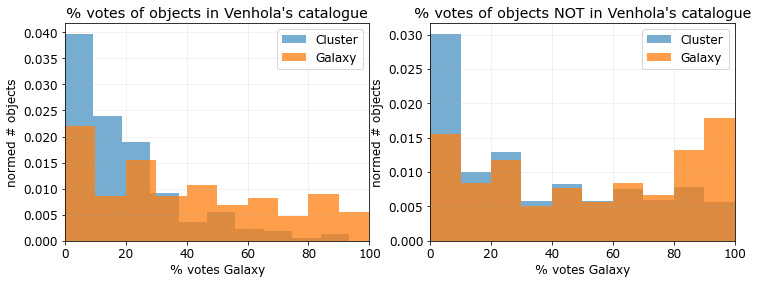

In [18]:
# filter df_tasks_with_props to only contain objects in the catalogue
in_catalogue = filterby_in_catalogue(df_tasks_with_props, catalogue_targets, True)
not_in_catalogue = filterby_in_catalogue(df_tasks_with_props, catalogue_targets, False)

dfs = [in_catalogue, not_in_catalogue]
titles = ["% votes of objects in Venhola's catalogue", "% votes of objects NOT in Venhola's catalogue"]
make_single_plot_galaxy_cluster(dfs, titles)

- ### Dataframe filtered, considering only users that made at least `n` classifications

In [19]:
# until I've refactored the plotting code below into functions, uncomment either OPTION 1 or OPTION 2

# OPTION 1
# threshold = 500
# df_tasks_with_props = df_threshold_props

# OR OPTION 2
threshold=0

In [20]:
df_threshold = make_df_vote_threshold(df, threshold)
df_threshold_props = make_df_tasks_with_props(df_threshold, candidate_names_classify, object_info)

first_classifications_per_user = []

# filter first 5 classifications per user
groupby_username = df_threshold.groupby(['user_name'])
for name, classifications in groupby_username:
    group = groupby_username.get_group(name)
    
    for idx, row in group.head().iterrows():
        first_classifications_per_user.append(row['classification_id'])
        
df_threshold_excluded_first = df_threshold[~df_threshold['classification_id'].isin(first_classifications_per_user)]

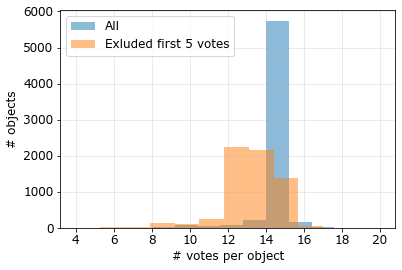

In [21]:
# plot number of votes per object for the filtered dataframe, if we wish
fig, fr = plt.subplots(figsize=(6,4))

grouped_threshold = df_threshold.groupby(['Filename'])
classification_count = np.array([len(classifications) for (object, classifications) in grouped_threshold])
ccount2 = np.array([len(classifications) for (object, classifications) in df_threshold_excluded_first.groupby(['Filename'])])

fr.hist(classification_count, alpha=0.5, label='All')
fr.hist(ccount2, alpha=0.5, label='Exluded first 5 votes')

fr.update({
    'xlabel': '# votes per object',
    'ylabel': '# objects'
})
fr.grid(alpha=0.3, which='both')
fr.legend()
plt.show()

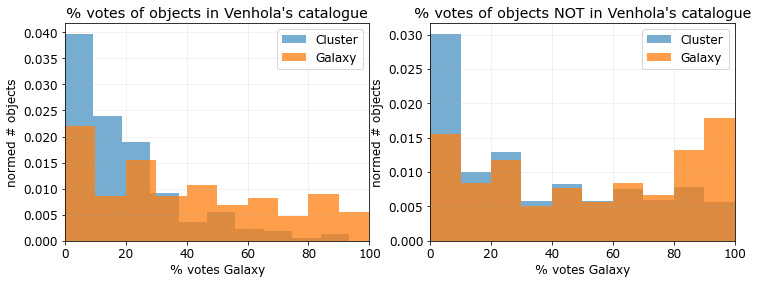

In [23]:
in_catalogue = filterby_in_catalogue(df_threshold_props, catalogue_targets, True)
not_in_catalogue = filterby_in_catalogue(df_threshold_props, catalogue_targets, False)

dfs = [in_catalogue, not_in_catalogue]
titles = ["% votes of objects in Venhola's catalogue", "% votes of objects NOT in Venhola's catalogue"]
make_single_plot_galaxy_cluster(dfs, titles)

- Do the same, but exclude first 5 votes per user:

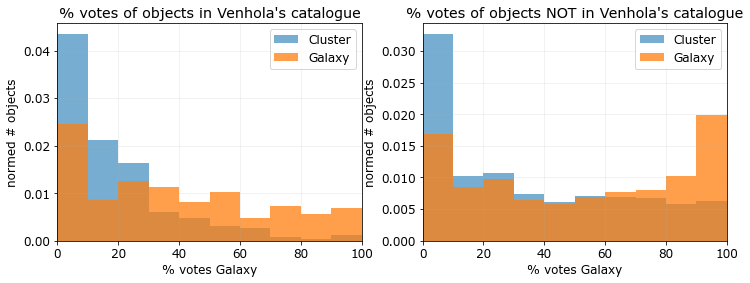

In [24]:
df_props2 = make_df_tasks_with_props(df_threshold_excluded_first, candidate_names_classify, object_info)

in_catalogue = filterby_in_catalogue(df_props2, catalogue_targets, True)
not_in_catalogue = filterby_in_catalogue(df_props2, catalogue_targets, False)

dfs = [in_catalogue, not_in_catalogue]
titles = ["% votes of objects in Venhola's catalogue", "% votes of objects NOT in Venhola's catalogue"]
make_single_plot_galaxy_cluster(dfs, titles)

---

In [27]:
# list of objects both in catalogue and raw dataframe
in_catalogue_and_spacefluff = list(set(catalogue_targets) & set(df['Filename']))

# list of objects in raw dataframe, not in df_tasks
_names_df = set(df['Filename'])
_names_df_tasks = set(df_tasks_with_props['name'])

difference = []
for name in _names_df:
    if not name in _names_df_tasks:
        difference.append(name)

# filter df to see the objects that didn't make it into df_tasks, but are in raw df
# df[df['Filename'].isin(difference)]  # uncomment to inspect

in_catalogue_and_sf = df_tasks_with_props[df_tasks_with_props['name'].isin(in_catalogue_and_spacefluff)]

---

## Plot parameters like `The Fornax Deep Survey with the VST - IV. A size and magnitude limited catalog...` fig. 15-17

The below plots are a recreation of figure 15-17 in Venhola (2018), with a distinction made between the objects for which  SpaceFluff volunteers voted strongly in favor of/against seeing a 'galaxy'.

- Plot all objects
- Plot objects with significant number of votes for 'galaxy'
- Plot objects with significant number of votes NOT for 'galaxy'

@note we're not strictly just looking for 'galaxy', but specifically for fluffy galaxies, but this is just an initial plot as inspection.

In [32]:
# xlim = [5,25]
xlim = [15,25]

In [28]:
m_r = df_tasks_with_props['r_mag']
mue_r = df_tasks_with_props['mue_r']
g = df_tasks_with_props['g']
r = df_tasks_with_props['r']
C = df_tasks_with_props['C']
Reff = df_tasks_with_props['Reff']

gal = df_tasks_with_props[df_tasks_with_props['% votes Galaxy'] > 75]
fluffy = gal[gal['% Fluffy'] > 75]   # can also check just the 'fluffy galaxies' (as voted by the people)
cat_and_fluffy = fluffy[fluffy['name'].isin(in_catalogue_and_spacefluff)]

not_gal = df_tasks_with_props[df_tasks_with_props['% votes Galaxy'] < 25]

- #### First, plot all objects, mostly 'galaxy' and mostly not 'galaxy':

In [29]:
def plot_venhola(df_with_props, plot_all, xlim=[5,25], savepath=False):
    gal = df_with_props[df_with_props['% votes Galaxy'] > 75]  
    not_gal = df_with_props[df_with_props['% votes Galaxy'] < 25]
    
    fluffy = gal[gal['% Fluffy'] > 75]   # just the 'fluffy galaxies' (as voted by the people)
    cat_and_fluffy = fluffy[fluffy['name'].isin(in_catalogue_and_spacefluff)]

    fig, fr = plt.subplots(3,1, figsize=(7,12))
    fig.tight_layout()

    if plot_all:
        fr[0].scatter(df_with_props['r_mag'], df_with_props['g']-df_with_props['r'] , alpha=0.25, label='all', s=6)
    fr[0].scatter(not_gal['r_mag'], not_gal.g-not_gal.r, alpha=0.4, label=r"$ < 25\%$ 'Galaxy'", s=6)
    fr[0].scatter(gal['r_mag'], gal.g-gal.r, alpha=0.4, label=r"$> 75\%$ 'Galaxy'", s=6)
    fr[0].update({
        'xlabel': r'$m_r$ [mag]',
        'ylabel': "g'-r'",
        "ylim": [-0.5, 3]
    })

    if plot_all:
        fr[1].scatter(df_with_props['r_mag'], df_with_props['mue_r'], alpha=0.25, label='all', s=6)
    fr[1].scatter(not_gal.r_mag, not_gal.mue_r, alpha=0.4, label=r"$< 25\%$ 'Galaxy'", s=6)
    fr[1].scatter(gal.r_mag, gal.mue_r, alpha=0.4, label=r"$> 75\%$ 'Galaxy'", s=6)
    fr[1].update({
        'xlabel': r'$m_r$ [mag]',
        'ylabel': r'$\mu_e,r$ [mag arcsec-2]',
        'ylim': [16,30]
    })

    if plot_all:
        fr[2].scatter(df_with_props['r_mag'], df_with_props['C'], alpha=0.25, label='all', s=6)
    fr[2].scatter(not_gal.r_mag, not_gal.C, alpha=0.4, label=r"$< 25\%$ 'Galaxy'", s=6)
    fr[2].scatter(gal.r_mag, gal.C, alpha=0.4, label=r"$> 75\%$ 'Galaxy'", s=6)
    fr[2].update({
        'xlabel': r'$m_r$ [mag]',
        'ylabel': 'C',
        'ylim': [1,6]
    })

    for i in range(len(fr)):
        fr[i].set_xlim(xlim),

    fr[1].set_ylim(fr[1].get_ylim()[::-1])    

    for i in range(len(fr)):
        fr[i].grid(alpha=0.3, which='both')
        fr[i].legend()
        fr[i].set_xlabel(r'$m_r$ [mag]'),
        
    if savepath:
        plt.savefig(savepath, dpi=250)

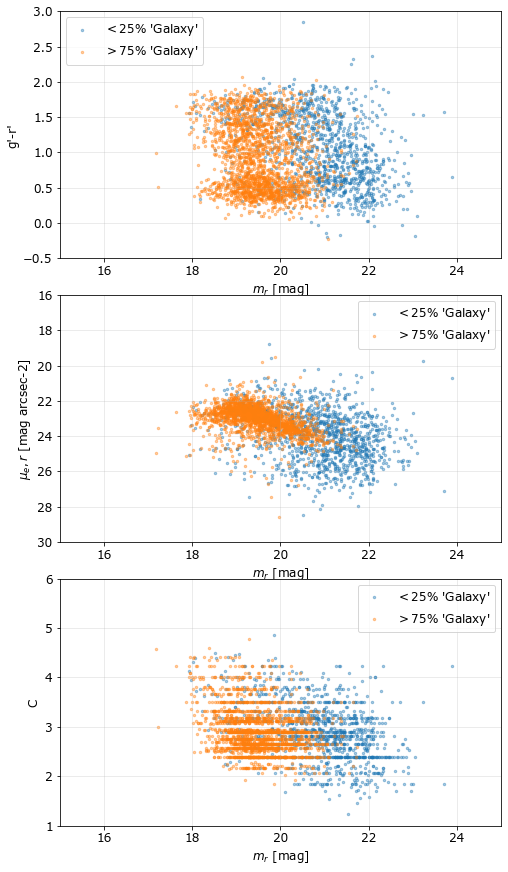

In [30]:
plot_venhola(df_tasks_with_props, plot_all=False, xlim=[15,25], savepath="./venhola_{}.png".format(threshold))

- #### Then, plot all, mostly 'galaxy', and mostly 'fluffy' (where 75% 'fluffy' means that 75% of the people who voted 'galaxy' for task0, then voted 'fluffy' for task1)

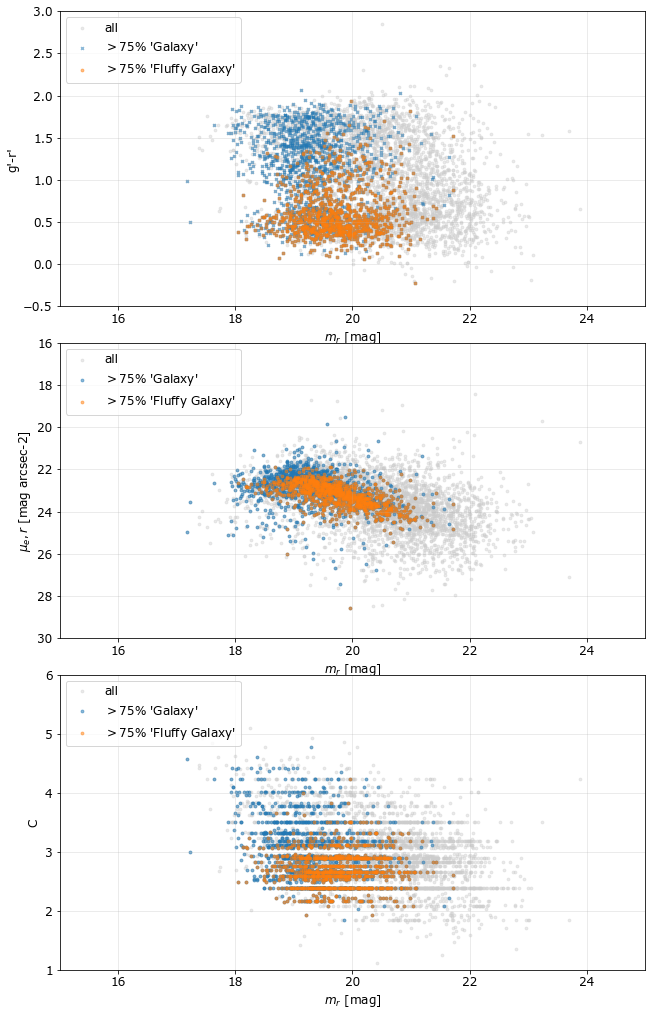

In [33]:
fig, fr = plt.subplots(3,1, figsize=(9,14))
fig.tight_layout()

fr[0].scatter(m_r, g-r, alpha=0.4, label='all', s=8, c='#ccc')
fr[0].scatter(gal['r_mag'], gal.g-gal.r, alpha=0.5, label=r"$> 75\%$ 'Galaxy'", s=8, marker='x')
fr[0].scatter(fluffy['r_mag'], fluffy.g-fluffy.r, alpha=0.5, label=r"$> 75\%$ 'Fluffy Galaxy'", s=8)
fr[0].update({
    'xlabel': r'$m_r$ [mag]',
    'ylabel': "g'-r'",
    "ylim": [-0.5, 3]
})

fr[1].scatter(m_r, mue_r, alpha=0.4, label='all', s=8, c='#ccc')
fr[1].scatter(gal.r_mag, gal.mue_r, alpha=0.5, label=r"$> 75\%$ 'Galaxy'", s=8)
fr[1].scatter(fluffy['r_mag'], fluffy['mue_r'], alpha=0.5, label=r"$> 75\%$ 'Fluffy Galaxy'", s=8)
fr[1].update({
    'xlabel': r'$m_r$ [mag]',
    'ylabel': r'$\mu_e,r$ [mag arcsec-2]',
    'ylim': [16,30]
})


fr[2].scatter(m_r, C, alpha=0.4, label='all', s=8, c='#ccc')
fr[2].scatter(gal.r_mag, gal.C, alpha=0.5, label=r"$> 75\%$ 'Galaxy'", s=8)
fr[2].scatter(fluffy['r_mag'], fluffy['C'], alpha=0.5, label=r"$> 75\%$ 'Fluffy Galaxy'", s=8)
fr[2].update({
    'xlabel': r'$m_r$ [mag]',
    'ylabel': 'C',
    'ylim': [1,6]
})

for i in range(len(fr)):
    fr[i].set_xlim(xlim),
    
fr[1].set_ylim(fr[1].get_ylim()[::-1])    

for i in range(len(fr)):
    fr[i].grid(alpha=0.3, which='both')
    fr[i].legend(loc='upper left')
    fr[i].set_xlabel(r'$m_r$ [mag]'),
    
plt.savefig('./venhola_fluffy_{}.png'.format(threshold))

- #### Finally, plot 
    - all objects,
    - the objects that are both in the catalogue and in SpaceFluff,
    - the objects in catalogue and spacefluff that people voted 'fluffy galaxy' for

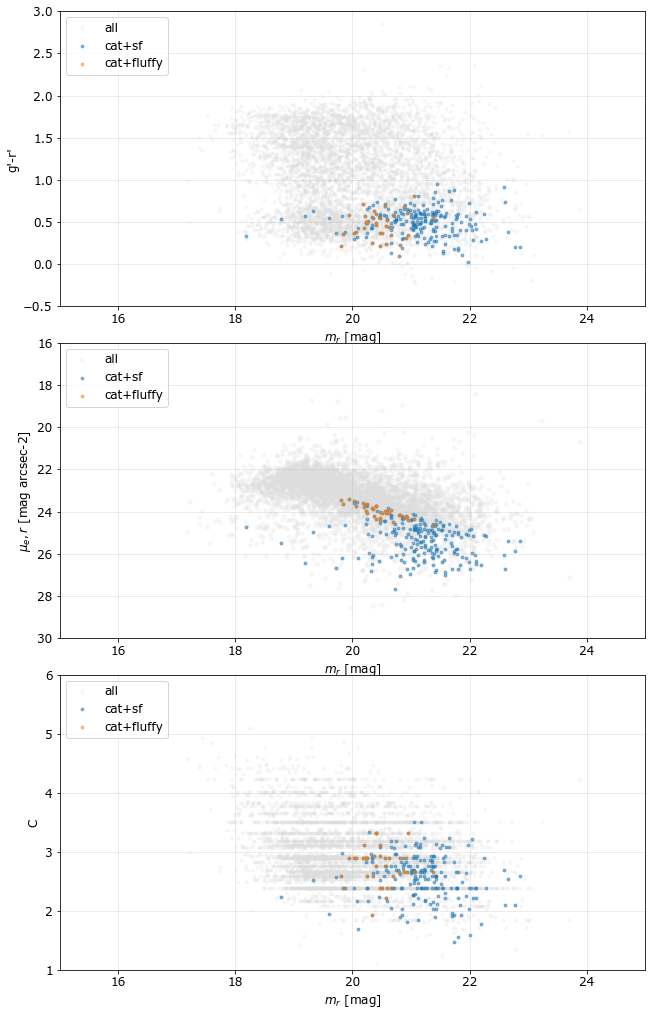

In [34]:
fig, fr = plt.subplots(3,1, figsize=(9,14))
fig.tight_layout()

fr[0].scatter(m_r, g-r, alpha=0.2, label='all', s=8, c='#ddd')
fr[0].scatter(in_catalogue_and_sf['r_mag'], in_catalogue_and_sf.g-in_catalogue_and_sf.r, alpha=0.5, label=r"cat+sf", s=8)
fr[0].scatter(cat_and_fluffy['r_mag'], cat_and_fluffy.g-cat_and_fluffy.r, alpha=0.5, label=r"cat+fluffy", s=8)
fr[0].update({
    'xlabel': r'$m_r$ [mag]',
    'ylabel': "g'-r'",
    "ylim": [-0.5, 3]
})

fr[1].scatter(m_r, mue_r, alpha=0.2, label='all', s=12, c='#ddd')
fr[1].scatter(in_catalogue_and_sf.r_mag, in_catalogue_and_sf.mue_r, alpha=0.5, label=r"cat+sf", s=8)
fr[1].scatter(cat_and_fluffy.r_mag, cat_and_fluffy.mue_r, alpha=0.5, label=r"cat+fluffy", s=8)
fr[1].update({
    'xlabel': r'$m_r$ [mag]',
    'ylabel': r'$\mu_e,r$ [mag arcsec-2]',
    'ylim': [16,30]
})


fr[2].scatter(m_r, C, alpha=0.2, label='all', s=8, c='#ddd')
fr[2].scatter(in_catalogue_and_sf.r_mag, in_catalogue_and_sf.C, alpha=0.5, label=r"cat+sf", s=8)
fr[2].scatter(cat_and_fluffy.r_mag, cat_and_fluffy.C, alpha=0.5, label=r"cat+fluffy", s=8)
fr[2].update({
    'xlabel': r'$m_r$ [mag]',
    'ylabel': 'C',
    'ylim': [1,6]
})

for i in range(len(fr)):
    fr[i].set_xlim(xlim),
    
fr[1].set_ylim(fr[1].get_ylim()[::-1])    

for i in range(len(fr)):
    fr[i].grid(alpha=0.3, which='both')
    fr[i].legend(loc='upper left')
    fr[i].set_xlabel(r'$m_r$ [mag]'),
    
plt.savefig('./venhola_catalogue_{}.png'.format(threshold))

- #### Figure 17 with all objects, mostly 'galaxy' and mostly not 'galaxy'

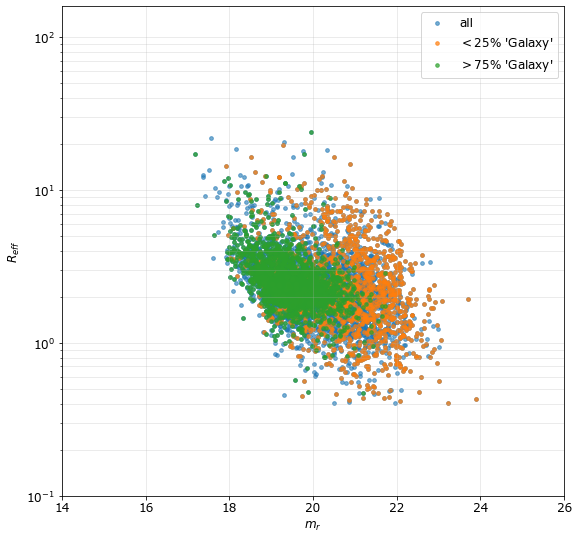

In [35]:
fig, fr = plt.subplots(figsize=(9,9))
fr.scatter(m_r, Reff, alpha=0.6, label='all', s=14)
fr.scatter(not_gal.r_mag, not_gal.Reff, alpha=0.7, label=r"$< 25\%$ 'Galaxy'", s=13)
fr.scatter(gal.r_mag, gal.Reff, alpha=0.7, label=r"$> 75\%$ 'Galaxy'", s=13)
fr.update({
    'yscale': 'log',
    'xlabel': r'$m_r$',
    'ylabel': r'$R_{eff}$',
    'ylim': [1e-1, 10**(2.2)],
    'xlim': [14, 26]
})
fr.grid(alpha=0.3, which='both')
fr.legend()